origin: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
translator: Hongpu Liu

In [1]:
%matplotlib inline

# 迁移学习教程
在本教程中，将要学习采用迁移学习来训练神经网络。关于迁移学习的更多参考，请阅读[cs
231n讲义](http://cs231n.github.io/transfer-learning/)。

讲义引用：

> 在实践中，只有非常少的人从随机初始化权重开始训练卷积神经网络，这是因为足具规模的数据集是相当稀有的。更常见的做法是，首先用一个非常大的数据集（例如ImageNet，该数据集包括分为1000个类别的1200万张图像）预训练卷积网络，然后用该网络作为后续任务的初值或者特征提取器。

这两个主要的迁移学习场景如下：

- **微调卷积网络：**用预训练网络（例如在ImageNet 1000数据集上训练的网络）来初始化的网络。接下来对网络进行正常训练。
- **卷积网络作为固定的特征提取器：**将网络中全连接层之外的权重固定，然后将最后的全连接层替换为新的随机初始化的全连接层，接下来只训练这些全连接层。

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy
# Translator: Hongpu Liu

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

## 1. 加载数据
下面将使用**torchvision**和**torch.utils.data**包来加载数据。

本例中要做的工作是训练一个模型来分类**蚂蚁**和**蜜蜂**。数据集每个分类有120张训练图像，验证集中每个分类75张图像。如果从头开始训练网络，该数据集太小而难于泛化。下面的例子中，由于使用了迁移学习，使得网络的泛化能力相当不错。

该数据集是ImageNet的一个相当小的子集。

> **注意**
> 可以从[这里](https://download.pytorch.org/tutorial/hymenoptera_data.zip)下载数据集，并解压缩到当前目录下。

In [3]:
# 训练集：进行数据增广和归一化
# 验证集：只进行归一化

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

# 定义数据集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                  for x in ['train', 'val']}

# 定义数据加载器
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# 数据集大小
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

### 1.1 图像可视化
通过可视化一些训练图像，来理解数据增广。

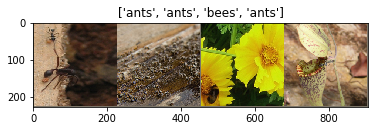

In [4]:
def imshow(inp, title=None):
    """显示张量"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 2. 训练模型
接下来编写用于训练模型的通用函数，包括：
- 学习率调度
- 保存最佳模型

在下面的例子中，**scheduler**参数是一个来自于**torch.optim.lr_scheduler**模块的学习率调度对象对象。

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 每轮迭代都分为训练和验证两个步骤
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) # 模型设置为训练模式
            else:
                model.train(False) # 模型设置为评估模式。
            
            running_loss = 0.0
            running_corrects = 0
            
            # 迭代数据
            for data in dataloaders[phase]:
                # 获得输入
                inputs, labels = data
                
                # 将输入封装到变量中
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                # 清零参数的梯度缓存
                optimizer.zero_grad()
                
                # 前馈
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # 只有训练过程进行反向传播
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # 统计
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'. format(
                phase, epoch_loss, epoch_acc))
            
            # 深拷贝模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

### 2.1 可视化模型预测
定义显示若干图像预测的通用函数：

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

## 3. 对卷积网络进行微调
加载预训练模型，并重置最后的全连接层。

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# 所有的参数都要优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 学习率衰减因子为每7轮为原来的0.1倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 3.1 训练过程
在CPU上大概需要15-25分钟，在GPU不超过1分钟。

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4105 Acc: 0.7992
val Loss: 0.2950 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.6828 Acc: 0.7541
val Loss: 0.2238 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.3506 Acc: 0.8730
val Loss: 0.2524 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4743 Acc: 0.8320
val Loss: 0.6320 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.4670 Acc: 0.8074
val Loss: 0.3193 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.6386 Acc: 0.7623
val Loss: 0.3429 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6331 Acc: 0.7746
val Loss: 0.2214 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4349 Acc: 0.8033
val Loss: 0.2045 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2885 Acc: 0.8852
val Loss: 0.2383 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2517 Acc: 0.8975
val Loss: 0.2161 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3306 Acc: 0.8566
val Loss: 0.2010 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.4088 Acc: 0.8033
val Loss: 0.2000 Acc: 0.9412

Ep

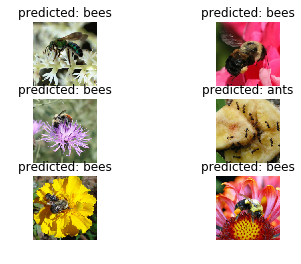

In [9]:
visualize_model(model_ft, num_images=6)

## 4. 卷积网络作为固定特征提取器
现在要将网络除了最后一层全部冻结。通过设置**requires_grad=False**来冻结参数，这样在**backward()**过程中将不会计算其梯度。

可以通过阅读[文档](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)来了解更多。

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 默认情况下，新构造的参数模块requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# 注意与前例不同，只有最后一层的参数需要进行优化
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 学习率衰减因子为0.1，每7轮进行一次衰减
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 4.1 训练与评估
在CPU上，与之前的场景相比只需要大概一半的时间。这是因为不需要计算那么多的权重梯度，但是前馈过程必须计算。

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6934 Acc: 0.6066
val Loss: 0.4859 Acc: 0.7843

Epoch 1/24
----------
train Loss: 0.5847 Acc: 0.7623
val Loss: 0.1919 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5301 Acc: 0.7500
val Loss: 0.2164 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3842 Acc: 0.8320
val Loss: 0.2317 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3932 Acc: 0.8197
val Loss: 0.1930 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4832 Acc: 0.8115
val Loss: 0.3164 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.3649 Acc: 0.8361
val Loss: 0.2052 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3511 Acc: 0.8648
val Loss: 0.1706 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3674 Acc: 0.8238
val Loss: 0.2053 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4889 Acc: 0.7828
val Loss: 0.1892 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3171 Acc: 0.8566
val Loss: 0.1942 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3309 Acc: 0.8730
val Loss: 0.1822 Acc: 0.9412

Ep

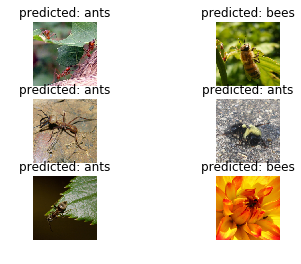

In [12]:
visualize_model(model_conv)

# plt.ioff()
# plt.show()